In [3]:
import multiprocess as mp
import numpy as np
from SwarmTracerClass import SwarmTracer
from ParticleTracerLatticeClass import ParticleTracerLattice
from ParticleClass import Particle,Swarm
from elementPT import Drift,HalbachBenderSimSegmented,CombinerHalbachLensSim,HalbachLensSim
import os
from ParticleTracerClass import ParticleTracer



In [4]:
pt=ParticleTracer(PTL)
particle=Particle(qi=np.array([-1e-10,-.1e-3,0.0]))

particle=pt.trace(particle,1e-5,.01,fastMode=False,accelerated=True)

NameError: name 'PTL' is not defined

In [ ]:
import warnings
import itertools
from math import sqrt,isclose
from typing import Optional,Union
import pandas as pd
from scipy.spatial.transform import Rotation as Rot
from shapely.geometry import Polygon
import numpy as np
import fastNumbaMethodsAndClass
from helperTools import arr_Product,iscloseAll,make_Odd
from HalbachLensClass import HalbachLens as _HalbachLensFieldGenerator
from HalbachLensClass import SegmentedBenderHalbach as _HalbachBenderFieldGenerator
from constants import SIMULATION_MAGNETON
import matplotlib.pyplot as plt
import scipy.optimize as spo
import time




LSep=1e-3
Lm=.0254
Lseg=Lm+LSep
rp=.01
yokeWidth=3e-3
rb=1.02
v0=210
m=1

ucAngTemp=np.arctan(Lseg/(2*(rb-rp-yokeWidth))) #value very near final value, good
#approximation

lens = _HalbachBenderFieldGenerator(rp, rb, ucAngTemp,Lm, numLenses=5,applyMethodOfMoments=True)

thetaArr=np.linspace(-ucAngTemp,ucAngTemp,100)
yArr=np.zeros(len(thetaArr))
def offset_Error(rOffset):
    if rOffset>rp:
        return np.nan
    xArr=(rb+rOffset)*np.cos(thetaArr)
    zArr=(rb+rOffset)*np.sin(thetaArr)
    coords=np.column_stack((xArr,yArr,zArr))
    F=lens.BNorm_Gradient(coords)*SIMULATION_MAGNETON
    Fr=np.linalg.norm(F[:,[0,2]],axis=1)
    FrMean=np.mean(Fr)
    FCen=m*v0**2/(rb+rOffset)
    return (FCen-FrMean)**2
#
# rOffsetArr=np.linspace(0.0,rp*.9,100)
# vals=[offset_Error(rOffset) for rOffset in rOffsetArr]
# plt.scatter(rOffsetArr,vals)
# plt.show()
# np.min(vals)
bounds=[(0.0,rp*.9)]
t=time.time()
sol=spo.minimize(offset_Error,(rp/2.0),bounds=bounds,method='Nelder-Mead',options={'xatol':1e-6}) #1.8372087865209717e-09 array([0.00388324])
print(time.time()-t)
rOffset=sol.x[0]
sol.fun,rOffset #(9.321391417934391e-05, 0.0038778991699218723)

In [1]:
import itertools
import os
from asyncDE import solve_Async
from typing import Union,Optional
import numpy as np
import warnings
from constants import DEFAULT_ATOM_SPEED
from storageRingOptimizer import LatticeOptimizer
from ParticleTracerLatticeClass import ElementDimensionError,ElementTooShortError,CombinerDimensionError
from elementPT import HalbachLensSim
import matplotlib.pyplot as plt
from elementPT import HalbachLensSim
from latticeModels import make_Injector_Version_1,make_Ring_Surrogate_Version_1,InjectorGeometryError
from latticeModels_Constants import constants_Version1,lockedDict
import dill
from injectionOptimizer import Injection_Model,surrogateParams

paramsInjector=np.array([0.28653747, 0.03600941, 0.1008204 , 0.01997145 ,0.14831874 ,0.03622285,
          0.01285372, 0.05       ,0.10830639, 0.21335858])

PTL_I=make_Injector_Version_1(paramsInjector)
PTL_R=make_Ring_Surrogate_Version_1(paramsInjector,surrogateParams)

model=Injection_Model(PTL_R,PTL_I)


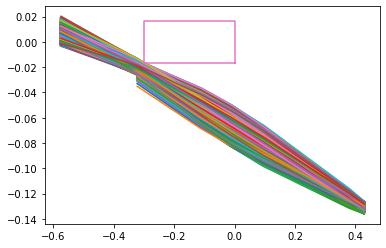

(108.3921891424954, 271.36403180203695)

In [4]:
%matplotlib inline
swarm=model.trace_Through_Injector_And_Transform_To_Ring(False)
swarm.num_Particles(weighted=True),model.swarmInjectorInitial.num_Particles(weighted=True) #(116.35938725733523, 271.36403180203695)

In [3]:
swarmInjectorTraced = model.swarmTracerInjector.trace_Swarm_Through_Lattice(
    model.swarmInjectorInitial.quick_Copy()
    , model.h, 1.0, parallel=False, copySwarm=False,
    accelerated=False,logPhaseSpaceCoords=True)

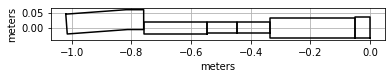

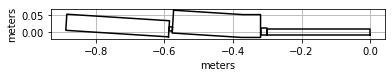

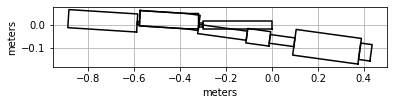

In [4]:
model.latticeInjector.show_Lattice()
model.latticeRing.show_Lattice()
model.show_Floor_Plan()

In [ ]:
deltar=model.latticeRing.combiner.r2-model.latticeInjector.combiner.r2
R=model.latticeRing.combiner.RIn#@model.latticeInjector.combiner.ROut
R

94

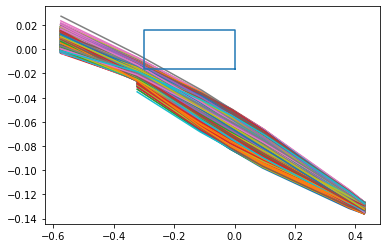

In [6]:
from shapely.geometry import LineString


def convert_Pos_Injector_Frame_To_Ring_Frame(X):
    X=X[:2].copy()
    X+=-model.latticeInjector.combiner.r2[:2]
    X=model.latticeInjector.combiner.RIn@model.latticeInjector.combiner.RIn@X
    X+=model.latticeRing.combiner.r2[:2]
    return X

def make_Shapely_Line_In_Ring_Frame_From_Injector_Particle(particle)->Optional[LineString]:
    if len(particle.elPhaseSpaceLog)==0:
        return None
    qList=[]
    for q,p in particle.elPhaseSpaceLog:
        qRingFrame_2D=convert_Pos_Injector_Frame_To_Ring_Frame(q)
        qList.append(qRingFrame_2D)
    line=LineString(qList)
    return line

def does_Injector_Particle_Clip_On_Ring(particle):
    line=make_Shapely_Line_In_Ring_Frame_From_Injector_Particle(particle)
    lens=model.latticeRing.elList[0]
    assert len(model.latticeRing.elList)==5 and type(lens) is HalbachLensSim
    return line.intersects(lens.SO_Outer)

clipped=0
for particle in swarmInjectorTraced.particles:
    line=make_Shapely_Line_In_Ring_Frame_From_Injector_Particle(particle)
    plt.plot(*line.coords.xy)
    # model.show_Floor_Plan()
    # line.intersects(model.latticeRing.elList[0].SO_Outer)
    clipped+=does_Injector_Particle_Clip_On_Ring(particle)
plt.plot(*model.latticeRing.elList[0].SO_Outer.exterior.xy)
clipped

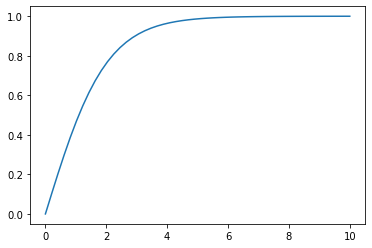

In [10]:
from scipy.special import expit
sigmoid=lambda x: 2*(expit(x)-.5)
xArr=np.linspace(0,10)
plt.plot(xArr,sigmoid(xArr))

In [ ]:
swarmInjectorTraced.particles[5].elPhaseSpaceLog[-1][0]

In [1]:
from injectionOptimizer import Injection_Model
from storageRingOptimizer import LatticeOptimizer,Solution

from ParticleTracerLatticeClass import ParticleTracerLattice
from ParticleClass import Swarm,Particle

PTL_Ring=ParticleTracerLattice()
PTL_Ring.add_Halbach_Lens_Sim(.02,.1)
PTL_Ring.add_Drift(.02)
PTL_Ring.add_Combiner_Sim_Lens(.15,.03)
PTL_Ring.add_Drift(.1)
PTL_Ring.add_Drift(.1)
PTL_Ring.end_Lattice(constrain=False)


PTL_Injector=ParticleTracerLattice(latticeType='injector')
PTL_Injector.add_Drift(.1)
PTL_Injector.add_Halbach_Lens_Sim(.01,.1)
PTL_Injector.add_Drift(.1)
PTL_Injector.add_Halbach_Lens_Sim(.01,.1)
PTL_Injector.add_Combiner_Sim_Lens(.15,.03)
PTL_Injector.end_Lattice()



In [2]:
model=Injection_Model(PTL_Ring,PTL_Injector)

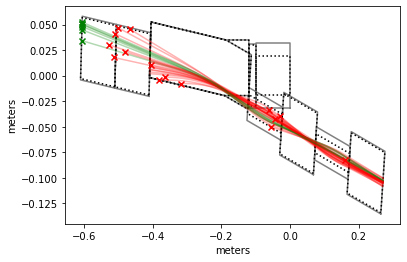

In [46]:
%matplotlib inline
model.show_Floor_Plan_And_Trajectories()

In [79]:
model.swarmInjectorInitial.particles=model.swarmInjectorInitial.particles[:100]
swarmInjectorTraced = model.swarmTracerInjector.trace_Swarm_Through_Lattice(
            model.swarmInjectorInitial.quick_Copy(), 2e-6, 1.0, parallel=False,
            fastMode=False, copySwarm=False, accelerated=False,logPhaseSpaceCoords=True)
swarmRingInitial = model.transform_Swarm_From_Injector_Frame_To_Ring_Frame(swarmInjectorTraced,
                                                                          copyParticles=True,onlyUnclipped=False)
swarmRingTraced=model.swarmTracerRing.trace_Swarm_Through_Lattice(swarmRingInitial,2e-6,1,fastMode=False,
                                                                 parallel=False)
# %matplotlib inline
# model.latticeRing.show_Lattice(swarm=swarmRingInitial,trueAspectRatio=False,showTraceLines=True)

In [82]:
from helperTools import *
from shapely.geometry import LineString
lensSO=PTL_Ring.elList[0].SO_Outer

for particleInj,particleRing in zip(swarmInjectorTraced,swarmRingTraced):
    assert not (particleInj.clipped and not particleRing.clipped) #this wouldn't make sense

    if particleInj.qArr is not None and len(particleInj.qArr)>1:
        qInj_RingFrame=np.array([model.convert_Pos_Injector_Frame_To_Ring_Frame(q) for q in particleInj.qArr])
        line=LineString(qInj_RingFrame[:,:2])
        assert lensSO.intersects(line) == model.does_Injector_Particle_Clip_On_Ring(particleInj) #test that clipping works
        #agrees

        if particleRing.qArr is not None and len(particleRing.qArr)>1:
            #assert particles are on top of each other at handoff between injector and ring, and that they are
            #very collinear
            assert iscloseAll(particleRing.qArr[0],qInj_RingFrame[-1],1e-12)
            assert iscloseAll(particleRing.qArr[1]-particleRing.qArr[0],qInj_RingFrame[-1]-qInj_RingFrame[-2],1e-10)

In [62]:
r2Inj=PTL_Injector.combiner.r2
r2Ring=PTL_Ring.combiner.r2

assert iscloseAll(model.convert_Pos_Injector_Frame_To_Ring_Frame(r2Inj),r2Ring,1e-12)
PTL_Ring.combiner.r1,PTL_Ring.combiner.inputOffset

(array([-0.12      ,  0.00771402,  0.        ]), -0.007739092989533963)

In [25]:
from helperTools import *
swarm=Swarm()
for q in (PTL_Injector.combiner.r1,PTL_Injector.combiner.r2):
    particle=Particle()
    particle.traced=True
    particle.qf,particle.pf=q,np.array([-PTL_Ring.v0Nominal,0,0])
    swarm.add(particle)
swarm=opt.transform_Swarm_From_Injector_Frame_To_Ring_Frame(swarm)
assert iscloseAll(swarm.particles[0].qi,PTL_Ring.combiner.r1,1e-12)
assert iscloseAll(swarm.particles[1].qi,PTL_Ring.combiner.r2,1e-12)

False

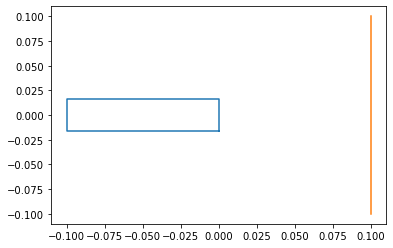

In [21]:
# opt.does_Injector_Particle_Clip_On_Ring()
from shapely.geometry import LineString
line=LineString([(.1,-.1),(.1,.1)])
SO=PTL_Ring.elList[0].SO_Outer
plt.plot(*SO.exterior.xy)
plt.plot(*line.xy)
particle=Particle()
particle.traced=True
particle.elPhaseSpaceLog=[(np.array([.1,-.1,0]), np.zeros(3)),(np.array([.1,.1,0]), np.zeros(3) )]
opt.does_Injector_Particle_Clip_On_Ring(particle)

In [30]:
2.6e-4 * 124500 *2`**3/30

8.632

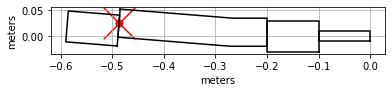

In [13]:
PTL_Ring.show_Lattice(particleCoords=coords)

In [ ]:
# PTL = ParticleTracerLattice(200.0, latticeType='storageRing')
#
# PTL.add_Halbach_Lens_Sim(.01, .5)
# PTL.add_Drift(.1)
# PTL.add_Combiner_Sim_Lens(.1, .02)
# PTL.add_Halbach_Lens_Sim(.01, .5)
# PTL.add_Halbach_Bender_Sim_Segmented(.0254 / 2, .01, None, 1, 0.0, rOffsetFact=1.)
# PTL.add_Halbach_Lens_Sim(.01, 1., constrain=True)
# PTL.add_Halbach_Bender_Sim_Segmented(.0254 / 2, .01, None, 1, 0.0, rOffsetFact=1.)
# PTL.end_Lattice(enforceClosedLattice=False, constrain=True,surpressWarning=True)

In [ ]:
def get_Error(fact):
    PTL = ParticleTracerLattice(200.0, latticeType='storageRing')


    PTL.add_Drift(.1)
    PTL.add_Halbach_Bender_Sim_Segmented(.0254 / 2, .01, 300, 1, 0.0, rOffsetFact=fact)
    PTL.end_Lattice(enforceClosedLattice=False, constrain=False,surpressWarning=True)

    from ParticleTracerClass import ParticleTracer
    from ParticleClass import Particle
    pt=ParticleTracer(PTL)
    particle=Particle(qi=np.array([-1e-10,-.1e-3,0.0]))

    particle=pt.trace(particle,1e-5,.01,fastMode=False,accelerated=False)
    PTL.show_Lattice(particle=particle,showTraceLines=True,trueAspectRatio=False)
    particle.plot_Orbit_Reference_Frame_Position()
    particle.plot_Energies(showOnlyTotalEnergy=True)
    error=np.std([q[1] for q in particle.qoArr])
    return error #0.0003401014791188453
# offsetList=list(np.linspace(.95,1.1,10))
# errors=[get_Error(offset) for offset in offsetList]

In [ ]:
import matplotlib.pyplot as plt
plt.plot(offsetList,errors)
plt.show()

In [ ]:

PTL = ParticleTracerLattice(200.0, latticeType='storageRing')
PTL.add_Drift(.1)
PTL.add_Combiner_Sim_Lens(.15,.04)
# PTL.add_Halbach_Lens_Sim(.02,.1,.9)
# PTL.add_Drift(.1)
# PTL.add_Halbach_Bender_Sim_Segmented(.0254 / 2, .01, 300, 1, 0.0)
PTL.end_Lattice(enforceClosedLattice=False, constrain=False,surpressWarning=True)
from ParticleTracerClass import ParticleTracer
from ParticleClass import Particle
pt=ParticleTracer(PTL)
particle=Particle(qi=np.array([-1e-10,2e-3,0.0]))
particle=pt.trace(particle,1e-5,.01,fastMode=False,accelerated=False)
%matplotlib inline
PTL.show_Lattice(particle=particle,showTraceLines=True,trueAspectRatio=False)



In [ ]:
PTL.elList[1].force(np.array([.1,0,0]))
PTL.elList[1].r2

In [ ]:
[q[1] for q in particle.qoArr]

In [ ]:
particle.plot_Orbit_Reference_Frame_Position()

In [ ]:
%matplotlib inline
from storageRingGeometries import Line,Kink,CappedSlicedBend
from storageRingGeometry import StorageRingGeometry
from storageRingGeometrySolver import StorageRingConstraintSolver
firstEl=Line(.5)
firstEl.place(np.array([0.0,0.0]),-np.pi)
Lcap=0.02135#PTL_True.bender1.Lcap



elements=[
    firstEl,
    Line(.1),
    Kink(-0.07288109082330438,L2,L1),
    Line(.5),
    CappedSlicedBend(.0127,240,magnetDepth,Lcap,1.),
    Line(1.5,constrained=True),
    CappedSlicedBend(.0127,230,magnetDepth,Lcap,1.0042770601252802)
]



storageRing=StorageRingGeometry(elements)
storageRing.build()
storageRing.show_Geometry()
solver=StorageRingConstraintSolver(storageRing,1.0)
params=solver.solve()
solver.update_Ring(params)
storageRing=solver.storageRing
# storageRing=solver.make_Valid_Storage_Ring()
storageRing.show_Geometry()
params

In [ ]:
import matplotlib.pyplot as plt
def build(PTL,storageRing):
    #todo: assert that each element lines up as expected
    for i,elements in enumerate(zip(PTL.elList,storageRing)):
        el_PTL,el_Geom=elements
        if type(el_Geom) is Line:
            el_PTL.r1=np.array([*el_Geom.pos_in,0])
            el_PTL.r2=np.array([*el_Geom.pos_out,0])
            el_PTL.nb=np.array([*el_Geom.n_in,0])
            el_PTL.ne=np.array([*el_Geom.n_out,0])

            theta=np.arctan2(el_Geom.n_out[1],el_Geom.n_out[0])
            if theta<0:
                theta+=np.pi*2
            el_PTL.theta=theta
            el_PTL.ROut = np.asarray([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
            el_PTL.RIn = np.asarray([[np.cos(-theta), -np.sin(-theta)], [np.sin(-theta), np.cos(-theta)]])
        if type(el_Geom) is Kink:

            n_out_perp=-np.flip(el_Geom.n_out)*np.array([-1,1])
            # r2+
            r2=(el_Geom.pos_out+n_out_perp*el_PTL.outputOffset)
            el_PTL.r2=np.array([*r2,0.0])
            el_PTL.r2[1]=0.014609633588606709

            r1=r2+-el_Geom.n_out*el_PTL.Lb+el_Geom.n_in*el_PTL.La
            el_PTL.r1=np.array([*r1,0])

            el_PTL.nb=np.array([*el_Geom.n_in,0])
            el_PTL.ne=np.array([*el_Geom.n_out,0])

            theta=np.arctan2(el_Geom.n_out[1],el_Geom.n_out[0])-np.pi #todo: i think this might be wrong, or not the right way to hink about it

            theta=theta+2*np.pi #conventino
            el_PTL.theta=theta

            rot=el_PTL.theta
            el_PTL.ROut = np.asarray([[np.cos(rot), -np.sin(rot)], [np.sin(rot), np.cos(rot)]]) #the rotation matrix for
            rot=-rot
            el_PTL.RIn = np.asarray([[np.cos(rot), -np.sin(rot)], [np.sin(rot), np.cos(rot)]])#np.linalg.inv(el_PTL.ROut)
        if type(el_Geom) is CappedSlicedBend:
            print("need to include shifting this over for offset effect")

            el_PTL.r1=np.array([*el_Geom.pos_in,0])
            el_PTL.r2=np.array([*el_Geom.pos_out,0])
            el_PTL.nb=np.array([*el_Geom.n_in,0])
            el_PTL.ne=np.array([*el_Geom.n_out,0])
            el_PTL.r0=np.array([*el_Geom.benderCenter,0])
            # print(el_PTL.r1)
            n=-el_Geom.n_in
            theta=np.arctan2(n[1],n[0])
            if theta<0:
                theta+=np.pi*2
            print(n,theta)
            el_PTL.theta=theta

            rot=el_PTL.theta- el_PTL.ang + np.pi / 2
            el_PTL.ROut = np.asarray([[np.cos(rot), -np.sin(rot)], [np.sin(rot), np.cos(rot)]]) #the rotation matrix for
            rot=-rot
            el_PTL.RIn = np.asarray([[np.cos(rot), -np.sin(rot)], [np.sin(rot), np.cos(rot)]])#np.linalg.inv(el_PTL.ROut)

build(PTL,storageRing)
# %matplotlib tk
PTL.make_Geometry()
PTL.show_Lattice(trueAspectRatio=True)

In [ ]:
%matplotlib inline
from ParticleTracerClass import ParticleTracer
from ParticleClass import Particle
pt=ParticleTracer(PTL)
particle=Particle(qi=np.array([-1e-10,-.1e-3,0.0]))

particle=pt.trace(particle,1e-5,1,fastMode=False,accelerated=False)
PTL.show_Lattice(particle=particle,showTraceLines=True,trueAspectRatio=False)
np.set_printoptions(precision=100)
print(particle.qf) #[-7.3317516263831284e-01  3.4424809584164646e-03 -5.2940775338183833e-06]

In [ ]:
particle.plot_Orbit_Reference_Frame_Position()

In [ ]:
el=PTL.elList[-1]
q=np.array([.5,.5,0])
# print(el.r1,el.r2)
# print(el.ROut)
# print(el.r2)
# print(el.transform_Element_Coords_Into_Lab_Frame(q))
# print(el.ROut)#@q[:2])#+el.r1[:2])
print(el.ROut)
print(el.RIn)

In [ ]:
PTL_Compare = ParticleTracerLattice(200.0, latticeType='storageRing')


PTL_Compare.add_Halbach_Lens_Sim(.01, .5)
PTL_Compare.add_Combiner_Sim_Lens(.1, .02)
PTL_Compare.add_Halbach_Lens_Sim(.01, .5)
PTL_Compare.add_Halbach_Bender_Sim_Segmented(.0254 / 2, .01, 251, 1.0419898531028318, 0.0, rOffsetFact=1.)
PTL_Compare.add_Halbach_Lens_Sim(.01, 1.1156855236430039, constrain=True)
PTL_Compare.add_Halbach_Bender_Sim_Segmented(.0254 / 2, .01, 251, 1.0418702761406033, 0.0, rOffsetFact=1.)
PTL_Compare.end_Lattice(enforceClosedLattice=True, constrain=True,surpressWarning=True)


In [ ]:
PTL_Compare.bender1.rb,PTL_Compare.bender2.rb,PTL_Compare.bender1.numMagnets,PTL_Compare.bender2.numMagnets

In [ ]:
el=PTL_Compare.elList[-1]
q=np.array([.5,.5,0])
# print(el.r1,el.r2)
# print(el.ROut)
# print(el.r2)
# print(el.transform_Element_Coords_Into_Lab_Frame(q))
# print(el.ROut)#@q[:2])#+el.r1[:2])
print(el.ROut)
print(el.RIn)


In [ ]:
from ParticleTracerClass import ParticleTracer
from ParticleClass import Particle
pt=ParticleTracer(PTL_Compare)
particle=Particle(qi=np.array([-1e-10,-1e-3,0.0]))

particle=pt.trace(particle,1e-5,1,fastMode=False,accelerated=False)
PTL_Compare.show_Lattice(particle=particle,showTraceLines=True,trueAspectRatio=False)
np.set_printoptions(precision=100)
print(particle.qf) #[-6.287784633004588e-01 -3.911591601543401e-03 -4.206831835417686e-06]

In [ ]:
particle.plot_Orbit_Reference_Frame_Position()

In [ ]:
#set first element
PTL.elList[0].r1=storageRing.elements[0].pos_in
PTL.elList[0].r2=storageRing.elements[0].pos_out
n=storageRing.elements[0].n_out
theta=np.arctan2(n[1],n[0])
PTL.elList[0].theta=theta
rot=theta
PTL.elList[0].ROut = np.asarray([[np.cos(rot), -np.sin(rot)], [np.sin(rot), np.cos(rot)]]) #the rotation matrix for
#rotating out of the element reference frame

In [ ]:
#set combiner
combEl=PTL.elList[1]
combShape=storageRing.elements[1]
n_out_perp=-np.flip(combShape.n_out)*np.array([-1,1])
# r2+
r2=(combShape.pos_out+n_out_perp*combEl.outputOffset)
combEl.r2=np.array([r2[0],r2[1],0.0])

r1=r2+-combShape.n_out*combEl.Lb+combShape.n_in*combEl.La
combEl.r1=np.array([r1[0],r1[1],0])

theta=PTL.elList[0].theta
theta = 2 * np.pi - combEl.ang - (
        np.pi - theta)  # Tilt the combiner down by el.ang so y=0 is perpindicular
# to the input. Rotate it 1 whole revolution, then back it off by the difference. Need to subtract
# np.pi because the combiner's input is not at the origin, but faces 'east'
theta = theta - 2 * np.pi * (theta // (2 * np.pi))  # the above logic can cause the element
# to have to rotate more than 360 deg


combEl.theta=theta

rot=combEl.theta
combEl.ROut = np.asarray([[np.cos(rot), -np.sin(rot)], [np.sin(rot), np.cos(rot)]]) #the rotation matrix for
#rotating out of the element reference frame
theta,combEl.ang

In [ ]:
PTL.make_Geometry()

In [ ]:
%matplotlib tk
PTL.show_Lattice()

In [ ]:
combEl.ROut

In [ ]:
from SwarmTracerClass import SwarmTracer
st=SwarmTracer(PTL_True)
swarm=st.initalize_PseudoRandom_Swarm_In_Phase_Space(5e-3,5.0,1.0,1000)
swarm=st.trace_Swarm_Through_Lattice(swarm,5e-6,1,fastMode=True)

In [ ]:
from math import isclose
swarm.survival_Rev()
survival=[p.revolutions for p in swarm]
print(max(survival),swarm.survival_Rev())
assert isclose(max(survival),6.07883077933884) and isclose(swarm.survival_Rev(),0.4981934261252685)